In [1]:
#!pip install pandas
#!pip install tensorflow[and-cuda]
#!pip install keras-tuner

In [2]:
#!pip install pandas
#!pip install networkx
#!pip install matplotlib
#!pip install scikit-learn

In [39]:
import pandas as pd
from keras.src.layers import Bidirectional

from component_module import drop_static_columns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# for keras tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt
import numpy as np
from time import time
import os

In [2]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1726745950.986475    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726745951.105976    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726745951.106520    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT DataSWaT 2015-12-23.csv")

#df.head()
df,  dropped_cols= drop_static_columns(df)
# convert time to seconds since midnight
# Convert 'Timestamp' column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['time_in_seconds'] = (df['Timestamp'].dt.hour * 3600 + df['Timestamp'].dt.minute * 60 + df['Timestamp'].dt.second)              
df.set_index('time_in_seconds', inplace=True)
df.drop(columns=['Timestamp', 'time'], inplace=True)

# normalised data
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)
df_normalised.to_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_2015_12_23_for_tf.csv",index=False)



In [3]:
df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_2015_12_23_for_tf.csv")

In [4]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,P602
0,-1.608031,1.824135,-1.55021,0.585352,2.475287,-0.112313,0.578473,0.085272,0.579321,-1.699887,...,1.386669,0.072135,0.363321,-0.274278,-0.576233,-0.282796,-1.05009,-0.233109,-0.096308,-0.088802
1,-1.608031,1.821131,-1.55021,0.585352,2.475287,-0.112313,0.581718,0.306260,0.579321,0.588275,...,1.386669,0.072135,-0.623212,-0.274278,0.735024,-0.328344,-1.05009,-0.233109,-0.096308,-0.088802
2,-1.608031,1.821131,-1.55021,0.585352,2.475287,-0.112313,0.589288,0.430235,0.579321,0.588275,...,1.386669,0.072135,-0.723537,-0.274278,0.735024,-0.442179,-1.05009,-0.246041,-0.096308,-0.088802
3,-1.608031,1.820797,-1.55021,0.585352,2.341305,-0.124024,0.597939,0.512685,0.579321,0.588275,...,1.386669,0.072135,-0.297175,0.905646,0.735024,-0.442179,-1.05009,-0.362587,-0.096308,-0.088802
4,-1.608031,1.818460,-1.55021,0.585352,2.341305,-0.124024,0.610196,0.565044,0.579321,0.588275,...,1.386669,0.072135,0.681068,0.905646,0.735024,-0.294165,-1.05009,-0.362587,-0.096308,-0.088802


In [5]:
component_map = list(df.columns)
len(component_map)

37

In [6]:
# check data is in time order
#df.sort_values(by='time_in_seconds', inplace=True)

In [16]:
df_test = df
df_test.shape

(86400, 37)

In [17]:
#df_test.set_index('time_in_seconds', inplace=True)
data_array = df_test.to_numpy()




In [18]:
# shape of array
data_array.shape

(86400, 37)

In [19]:
# dataset in single slices of array so 1 second rows
#dataset.element_spec

In [20]:
# Window size in seconds
window_size = 20
# Define batch of windows to process in parallel before updating weights 
batch_size = 32


def windowed_dataset(data_array, window_size, batch_size):
    '''
    get full dataset as np array
    :param series: 
    :param window_size: 
    :param batch_size: 
    :return: 
    '''
    
    # Create a TensorFlow dataset from the NumPy array
    dataset = tf.data.Dataset.from_tensor_slices(data_array)

    # Window the dataset into n second long slices with a 1 sec shift between each
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # Flatten the windowed dataset for input layer
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split window into features and labels (last row)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    
    # batch 
    dataset = dataset.batch(batch_size)
    
    # set indefinite repeat to allow looping back through
    #dataset = dataset.repeat()
    
    return dataset
    
    

In [21]:
split_time = int(data_array.shape[0] * 0.8)
train_dataset = data_array[:split_time]
val_dataset = data_array[split_time:]
train_dataset.shape
val_dataset.shape

(17280, 37)

In [22]:
train_dataset = windowed_dataset(train_dataset, window_size, batch_size)
val_dataset = windowed_dataset(val_dataset, window_size, batch_size)

I0000 00:00:1726746560.924551    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726746560.924863    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726746560.925046    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726746561.017542    5034 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [23]:
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (19, 37)
    print("Label shape: ", label.shape)        # Should be (37,)

Features shape:  (32, 19, 37)
Label shape:  (32, 1, 37)


2024-09-19 12:49:21.573841: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
# Count the number of windows
num_windows = train_dataset.reduce(0, lambda x, _: x + 1).numpy() * batch_size


print(f"Number of windows: {num_windows}")

Number of windows: 69120


# split data
train_size = int(0.8 * num_windows)
train_dataset = windowed_dataset.take(train_size)
val_dataset = windowed_dataset.skip(train_size)

# batch data
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [25]:
for feature, lable in train_dataset.take((1)):
    print(feature.numpy().shape)

(32, 19, 37)


2024-09-19 12:49:27.644648: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
(window_size - 1, data_array.shape[1])

(19, 37)

# Hyperparameter Optimisation



In [43]:
# Directory for model performance logs
LOG_DIR = os.path.join("my_tuner_logs")

In [54]:
def build_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
   
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with 50 units (neurons) and 
    model.add(LSTM(50))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.001)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model, epochs, steps_per_epoch



In [55]:
def build_bi_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add bidirectional LSTM layer with 50 units (neurons) 
    model.add(Bidirectional(LSTM(50)))
       
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.0001)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model, epochs, steps_per_epoch



In [40]:
def build_model_tuner(hp):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    # Add an LSTM layer with tuner range 
    model.add(LSTM(units=lstm_units))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    #epochs = 10
    
    #batch_size = 32
    # floor steps per epoch calculated to avoid error
    #steps_per_epoch = num_windows // batch_size 
    
    return model #, epochs, steps_per_epoch



In [42]:
# keras tuner to find optimum model
tuner = RandomSearch(build_model_tuner,
                     objective = "val_loss",
                     max_trials = 5,
                     executions_per_trial = 1,
                     directory = LOG_DIR,
                     project_name = "lstm_all_data"
                     )

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 37)             │         1,221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,237 (43.89 KB)

 Trainable params: 11,237 (43.89 KB)

 Non-trainable params: 0 (0.00 B)

## Tuner Version

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the tuner
tuner.search(
    train_dataset,  # Pass your windowed and batched training dataset
    epochs=10,
    validation_data=val_dataset,  # Pass your windowed and batched validation dataset
    callbacks=[early_stop]
)

Trial 5 Complete [00h 01m 51s]
val_loss: 0.2512055039405823

Best val_loss So Far: 0.2512055039405823
Total elapsed time: 00h 08m 23s


In [47]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         1,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,997 (363.27 KB)

 Trainable params: 92,997 (363.27 KB)

 Non-trainable params: 0 (0.00 B)

/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         1,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,997 (363.27 KB)

 Trainable params: 92,997 (363.27 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Rebuild the model and load weights from the best model
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         1,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,997 (363.27 KB)

 Trainable params: 92,997 (363.27 KB)

 Non-trainable params: 0 (0.00 B)

/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [52]:
# Evaluate best model on the validation dataset
val_loss, val_mae = best_model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2260 - mae: 0.2580
Validation Loss: 0.2512055039405823, Validation MAE: 0.2687811851501465


2024-09-19 13:25:08.230352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:25:08.230414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:25:08.230433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [59]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_history = best_model.fit(
    train_dataset,
    epochs=epochs,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

Epoch 1/10
   2153/Unknown 11s 5ms/step - loss: 0.2146 - mae: 0.2195

2024-09-19 13:29:04.087932: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 16229211591247083825
2024-09-19 13:29:04.087983: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14520922815371662895
2024-09-19 13:29:04.087997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:29:04.088007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2538432719088847330
2024-09-19 13:29:04.088022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when 

2160/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.2145 - mae: 0.2194 - val_loss: 0.2525 - val_mae: 0.2605
Epoch 2/10
  29/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.3365 - mae: 0.3948

2024-09-19 13:29:05.452399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:29:05.452468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:29:05.452500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958


2149/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1930 - mae: 0.2013

2024-09-19 13:29:16.008974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:29:16.009032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2538432719088847330
2024-09-19 13:29:16.009051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1930 - mae: 0.2012 - val_loss: 0.2596 - val_mae: 0.2706
Epoch 3/10
2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1887 - mae: 0.1952

2024-09-19 13:29:28.149378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:29:28.149424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.1887 - mae: 0.1952 - val_loss: 0.2506 - val_mae: 0.2637
Epoch 4/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1875 - mae: 0.1960 - val_loss: 0.2505 - val_mae: 0.2829
Epoch 5/10
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1817 - mae: 0.1890 - val_loss: 0.2703 - val_mae: 0.2798
Epoch 6/10
  33/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2134 - mae: 0.3131

2024-09-19 13:29:55.135620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:29:55.135673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:29:55.135686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958


2152/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1802 - mae: 0.1873

2024-09-19 13:30:05.108658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1802 - mae: 0.1872 - val_loss: 0.2702 - val_mae: 0.2708
Epoch 7/10
  31/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1658 - mae: 0.2518

2024-09-19 13:30:06.638544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738


2152/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1771 - mae: 0.1822

2024-09-19 13:30:16.538138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:30:16.538190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2538432719088847330
2024-09-19 13:30:16.538201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1771 - mae: 0.1821 - val_loss: 0.2392 - val_mae: 0.2474
Epoch 8/10
  27/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1536 - mae: 0.2591

2024-09-19 13:30:18.061795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:30:18.061844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:30:18.061867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1724 - mae: 0.1772

2024-09-19 13:30:29.837153: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 16229211591247083825
2024-09-19 13:30:29.837200: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14520922815371662895
2024-09-19 13:30:29.837216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:30:29.837228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2538432719088847330
2024-09-19 13:30:29.837239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1724 - mae: 0.1771 - val_loss: 0.2544 - val_mae: 0.2627
Epoch 9/10
  15/2160 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.1394 - mae: 0.2371

2024-09-19 13:30:31.727250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:30:31.727308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:30:31.727317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958


2151/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1706 - mae: 0.1749

2024-09-19 13:30:42.450139: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 16229211591247083825
2024-09-19 13:30:42.450176: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14520922815371662895
2024-09-19 13:30:42.450185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:30:42.450191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2538432719088847330
2024-09-19 13:30:42.450197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1706 - mae: 0.1749 - val_loss: 0.2591 - val_mae: 0.2678
Epoch 10/10
  30/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1445 - mae: 0.2670

2024-09-19 13:30:43.893436: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-19 13:30:43.893489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:30:43.893505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:30:43.893517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1711 - mae: 0.1754

2024-09-19 13:30:54.035678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3324336879837216812
2024-09-19 13:30:54.035732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2538432719088847330
2024-09-19 13:30:54.035750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16185397615036687080


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1711 - mae: 0.1754 - val_loss: 0.2380 - val_mae: 0.2518


2024-09-19 13:30:55.383097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9686566110102941607
2024-09-19 13:30:55.383165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4295549528250011738
2024-09-19 13:30:55.383179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1575396117144270958


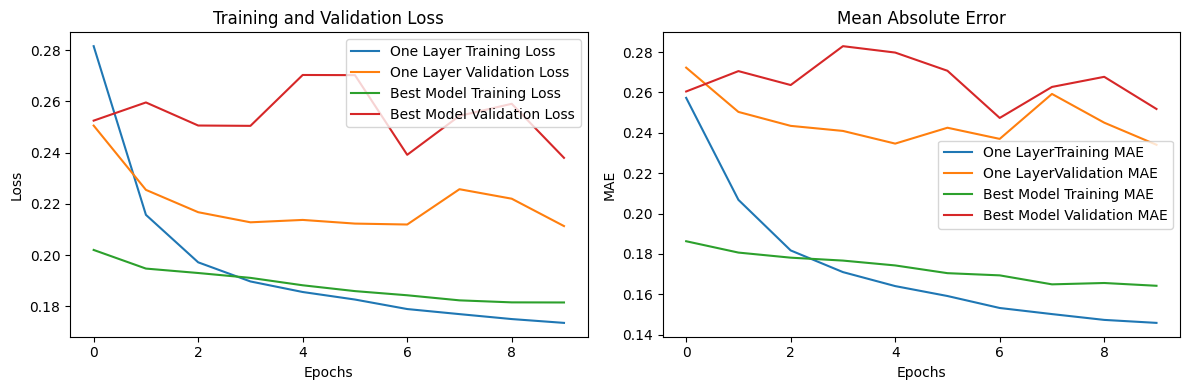

In [66]:
compare_models(history, best_history, "One Layer", "Best Model")

## Original Models

In [56]:
model, epochs, steps_per_epoch = build_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 37)             │         1,887 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,487 (76.12 KB)

 Trainable params: 19,487 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
bi_model, epochs, bi_steps_per_epoch = build_bi_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100)            │        35,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │         3,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,937 (152.10 KB)

 Trainable params: 38,937 (152.10 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
history = model.fit(
    train_dataset,
    epochs=epochs,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)


Epoch 1/10
   2152/Unknown 10s 4ms/step - loss: 0.3564 - mae: 0.3234

2024-09-19 13:26:43.979760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:26:43.979813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:26:43.979827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.3561 - mae: 0.3232 - val_loss: 0.2506 - val_mae: 0.2723
Epoch 2/10
  37/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4003 - mae: 0.4399

2024-09-19 13:26:45.270107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:26:45.270153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:26:45.270168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2148/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2282 - mae: 0.2426

2024-09-19 13:26:54.591050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:26:54.591096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:26:54.591107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.2282 - mae: 0.2424 - val_loss: 0.2255 - val_mae: 0.2504
Epoch 3/10
  40/2160 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2276 - mae: 0.3190

2024-09-19 13:26:55.849413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:26:55.849448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:26:55.849456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2159/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1940 - mae: 0.2033

2024-09-19 13:27:05.162997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:27:05.163039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160
2024-09-19 13:27:05.163133: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5511171295434125403
2024-09-19 13:27:05.163192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:27:05.163207: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 13693412891148754893


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1940 - mae: 0.2033 - val_loss: 0.2168 - val_mae: 0.2435
Epoch 4/10
  33/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1574 - mae: 0.2647

2024-09-19 13:27:06.465297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:27:06.465358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:27:06.465377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2147/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1811 - mae: 0.1867

2024-09-19 13:27:15.469082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:27:15.469150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:27:15.469171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1811 - mae: 0.1866 - val_loss: 0.2128 - val_mae: 0.2410
Epoch 5/10
2155/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1749 - mae: 0.1780

2024-09-19 13:27:25.685544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1750 - mae: 0.1780 - val_loss: 0.2137 - val_mae: 0.2347
Epoch 6/10
  39/2160 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1196 - mae: 0.2114

2024-09-19 13:27:26.867381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:27:26.867429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:27:26.867445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2151/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1710 - mae: 0.1712

2024-09-19 13:27:35.994728: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5511171295434125403
2024-09-19 13:27:35.994765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:27:35.994769: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 13693412891148754893
2024-09-19 13:27:35.994786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:27:35.994796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1711 - mae: 0.1711 - val_loss: 0.2123 - val_mae: 0.2425
Epoch 7/10
  30/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1211 - mae: 0.2078

2024-09-19 13:27:37.333890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:27:37.333936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:27:37.333951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2149/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1660 - mae: 0.1635

2024-09-19 13:27:47.894520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.1661 - mae: 0.1635 - val_loss: 0.2120 - val_mae: 0.2370
Epoch 8/10
  32/2160 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1048 - mae: 0.1938

2024-09-19 13:27:49.195441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:27:49.195492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:27:49.195509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1631 - mae: 0.1589

2024-09-19 13:27:58.718697: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5511171295434125403
2024-09-19 13:27:58.718737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:27:58.718746: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 13693412891148754893
2024-09-19 13:27:58.718759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:27:58.718769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1631 - mae: 0.1588 - val_loss: 0.2257 - val_mae: 0.2593
Epoch 9/10
  36/2160 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0865 - mae: 0.1814 

2024-09-19 13:28:00.218474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:28:00.218525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:28:00.218545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2151/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1604 - mae: 0.1552

2024-09-19 13:28:09.928114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:28:09.928163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:28:09.928176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.1604 - mae: 0.1552 - val_loss: 0.2220 - val_mae: 0.2450
Epoch 10/10
  18/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0893 - mae: 0.1899

2024-09-19 13:28:11.734655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:28:11.734698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:28:11.734709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


2147/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1583 - mae: 0.1523

2024-09-19 13:28:20.825409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15810791191437411751
2024-09-19 13:28:20.825452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3780649048345829834
2024-09-19 13:28:20.825460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4720277067683696160


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1584 - mae: 0.1522 - val_loss: 0.2113 - val_mae: 0.2341


2024-09-19 13:28:22.626880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11693704415943412125
2024-09-19 13:28:22.626923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9689338733867943691
2024-09-19 13:28:22.626940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15108502902711309790


In [27]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
bi_history = bi_model.fit(
    train_dataset,
    epochs=epochs,
    #steps_per_epoch=bi_steps_per_epoch,
    validation_data=val_dataset
)



Epoch 1/10
   2152/Unknown 13s 6ms/step - loss: 0.5446 - mae: 0.4697

2024-09-18 22:47:18.454339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:47:18.454385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:47:18.454398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.5442 - mae: 0.4694 - val_loss: 0.2896 - val_mae: 0.3069
Epoch 2/10
  27/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.3418 - mae: 0.4109

2024-09-18 22:47:19.966980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:47:19.967036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:47:19.967053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2913 - mae: 0.2860

2024-09-18 22:47:32.610430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:47:32.610479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:47:32.610492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.2912 - mae: 0.2859 - val_loss: 0.2401 - val_mae: 0.2684
Epoch 3/10
  28/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2140 - mae: 0.3236

2024-09-18 22:47:33.955281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:47:33.955323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:47:33.955347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2252 - mae: 0.2320

2024-09-18 22:47:46.209628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:47:46.209673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:47:46.209686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.2252 - mae: 0.2319 - val_loss: 0.2102 - val_mae: 0.2454
Epoch 4/10
  20/2160 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.1660 - mae: 0.2810

2024-09-18 22:47:47.579264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:47:47.579317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:47:47.579327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1962 - mae: 0.2035

2024-09-18 22:48:01.412614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:01.412687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:01.412698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1962 - mae: 0.2035 - val_loss: 0.1916 - val_mae: 0.2289
Epoch 5/10
  23/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1288 - mae: 0.2444

2024-09-18 22:48:03.057834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:03.057885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:03.057899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1807 - mae: 0.1864

2024-09-18 22:48:16.401675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:16.401726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:16.401743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
2024-09-18 22:48:16.401751: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10674525157249131382
2024-09-18 22:48:16.401759: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17791042572033723944


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1807 - mae: 0.1863 - val_loss: 0.1807 - val_mae: 0.2197
Epoch 6/10
  29/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1024 - mae: 0.2143

2024-09-18 22:48:17.938559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:17.938607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:17.938634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2154/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1716 - mae: 0.1744

2024-09-18 22:48:30.238148: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-09-18 22:48:30.238194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:30.238209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:30.238223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
2024-09-18 22:48:30.238232: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10674525157249131382
2024-09-18 22:48:30.238241: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17791042572033723944


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1716 - mae: 0.1744 - val_loss: 0.1737 - val_mae: 0.2130
Epoch 7/10
  25/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0910 - mae: 0.1989

2024-09-18 22:48:31.656895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:31.656934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:31.656941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2159/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1661 - mae: 0.1660

2024-09-18 22:48:44.090963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:44.091013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:44.091030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1661 - mae: 0.1660 - val_loss: 0.1688 - val_mae: 0.2075
Epoch 8/10
  23/2160 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0834 - mae: 0.1882

2024-09-18 22:48:45.484705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:45.484756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:48:45.484774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1624 - mae: 0.1598

2024-09-18 22:48:57.449536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189
2024-09-18 22:48:57.449580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10365198292974382595
2024-09-18 22:48:57.449605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4399257156728570348
2024-09-18 22:48:57.449613: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10674525157249131382
2024-09-18 22:48:57.449619: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17791042572033723944


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1624 - mae: 0.1598 - val_loss: 0.1649 - val_mae: 0.2029
Epoch 9/10
  25/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0772 - mae: 0.1776

2024-09-18 22:48:58.800370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:48:58.800423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2154/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1595 - mae: 0.1548

2024-09-18 22:49:11.532043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2296336475836276189


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.1596 - mae: 0.1548 - val_loss: 0.1619 - val_mae: 0.1991
Epoch 10/10
  27/2160 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0724 - mae: 0.1679

2024-09-18 22:49:13.025087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839
2024-09-18 22:49:13.025125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14724423377198096110
2024-09-18 22:49:13.025131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4248753676991465364


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.1574 - mae: 0.1506 - val_loss: 0.1598 - val_mae: 0.1961


2024-09-18 22:49:26.982445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8765535484002034839


In [46]:
#history_dict['val_mae']

[0.30992981791496277,
 0.3008570373058319,
 0.28729987144470215,
 0.2620809078216553,
 0.2625470459461212,
 0.269218385219574,
 0.2402947098016739,
 0.24070829153060913,
 0.26532796025276184,
 0.2421676367521286,
 0.24359402060508728,
 0.2437315434217453,
 0.24171429872512817,
 0.261157363653183,
 0.252514123916626]

In [44]:
#history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

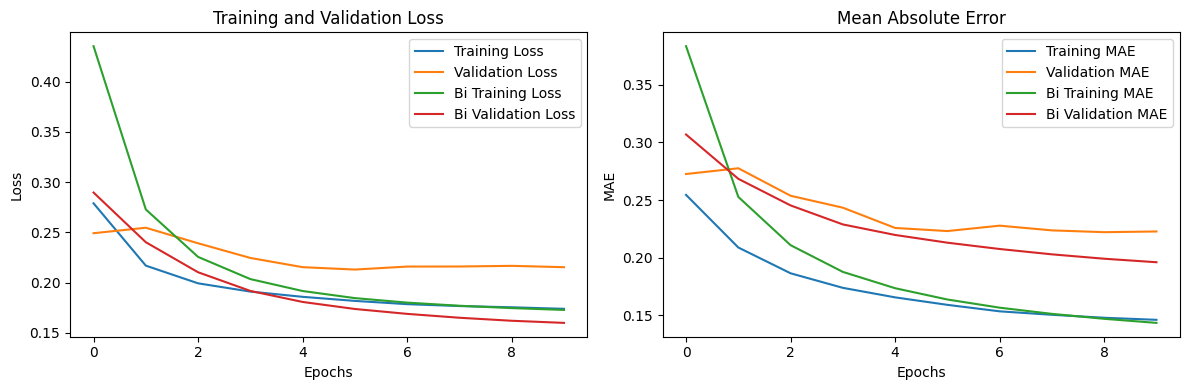

In [28]:


# Assuming `history` is the output from model.fit()

history_dict = history.history
bi_history_dict = bi_history.history

# Plot training & validation loss
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
if 'val_loss' in history_dict:
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    
plt.plot(bi_history_dict['loss'], label='Bi Training Loss')
if 'val_loss' in bi_history_dict:
    plt.plot(bi_history_dict['val_loss'], label='Bi Validation Loss')
    

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy (if available)
plt.subplot(1, 2, 2)

if 'mae' in history_dict:
    plt.plot(history_dict['mae'], label='Training MAE')
if 'val_mae' in history_dict:
    plt.plot(history_dict['val_mae'], label='Validation MAE')
 
if 'mae' in bi_history_dict:
    plt.plot(bi_history_dict['mae'], label='Bi Training MAE')
if 'val_mae' in bi_history_dict:
    plt.plot(bi_history_dict['val_mae'], label='Bi Validation MAE')  

plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [65]:
def compare_models(history_1, history_2, history_1_name="Model 1", history_2_name="Model 2"):  
    
    # Assuming `history` is the output from model.fit()
    
    history_1_dict = history_1.history
    history_2_dict = history_2.history
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_1_dict['loss'], label=f'{history_1_name} Training Loss')
    if 'val_loss' in history_1_dict:
        plt.plot(history_1_dict['val_loss'], label=f'{history_1_name} Validation Loss')
        
    plt.plot(history_2_dict['loss'], label=f'{history_2_name} Training Loss')
    if 'val_loss' in history_2_dict:
        plt.plot(history_2_dict['val_loss'], label=f'{history_2_name} Validation Loss')
        
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy (if available)
    plt.subplot(1, 2, 2)
    
    if 'mae' in history_1_dict:
        plt.plot(history_1_dict['mae'], label=f'{history_1_name}Training MAE')
    if 'val_mae' in history_1_dict:
        plt.plot(history_1_dict['val_mae'], label=f'{history_1_name}Validation MAE')
     
    if 'mae' in history_2_dict:
        plt.plot(history_2_dict['mae'], label=f'{history_2_name} Training MAE')
    if 'val_mae' in history_2_dict:
        plt.plot(history_2_dict['val_mae'], label=f'{history_2_name} Validation MAE')  
    
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()


In [16]:
model.save('swat_lstm_100s.keras')

# Open Saved Model

In [20]:
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
model_window = 100

In [21]:
# Reshape the input from data_array to add the batch dimension
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 37)

# Make predictions
predictions = swat_lstm.predict(reshaped_input)

# Print predictions
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[-1.6873796   1.0725484  -1.6856784   0.5893998   1.2647659  -0.6372988
   0.81754637  0.5705057   0.5782185   0.5621133  -1.0134225   0.46552265
   0.3625184  -1.7182541  -0.08421671  0.45475912 -0.03200638 -0.09545343
  -0.00451893  0.34572366 -0.7700037   0.22403386  0.01046308 -1.1046661
  -0.38610268  0.06470605  0.83374614  1.4891282   0.08482892  0.150914
  -0.49433717  0.16404936 -0.7478318  -1.3892689  -0.76368266 -0.03951834
  -0.00188439]]


In [22]:
actual = data_array[model_window-1:model_window, :]

In [27]:
reshaped_input.shape

(1, 99, 37)

In [25]:
actual

array([[-1.60803075,  1.39821286, -1.55020996,  0.58535159,  2.14028964,
        -0.51839683,  0.71329708,  0.61367085,  0.57932135,  0.58827456,
        -0.92233481,  0.51362799,  0.46787354, -1.57205191, -0.04912496,
         0.48112757, -0.11892534, -0.12449482, -0.01128411,  0.46178413,
        -0.79145985,  0.90939238,  0.15634357, -1.11978876, -0.34043019,
         0.93175224,  1.00190234,  1.50947237, -0.12515386, -1.29212782,
        -0.27427769,  0.68043468, -0.55601419, -1.29954125, -0.49206393,
        -0.09630808, -0.08880187]])

In [23]:
difference = actual - predictions

# Print results
print("Predictions:\n", predictions)
print("Actual Values:\n", actual)
print("Difference:\n", difference)

Predictions:
 [[-1.6873796   1.0725484  -1.6856784   0.5893998   1.2647659  -0.6372988
   0.81754637  0.5705057   0.5782185   0.5621133  -1.0134225   0.46552265
   0.3625184  -1.7182541  -0.08421671  0.45475912 -0.03200638 -0.09545343
  -0.00451893  0.34572366 -0.7700037   0.22403386  0.01046308 -1.1046661
  -0.38610268  0.06470605  0.83374614  1.4891282   0.08482892  0.150914
  -0.49433717  0.16404936 -0.7478318  -1.3892689  -0.76368266 -0.03951834
  -0.00188439]]
Actual Values:
 [[-1.60803075  1.39821286 -1.55020996  0.58535159  2.14028964 -0.51839683
   0.71329708  0.61367085  0.57932135  0.58827456 -0.92233481  0.51362799
   0.46787354 -1.57205191 -0.04912496  0.48112757 -0.11892534 -0.12449482
  -0.01128411  0.46178413 -0.79145985  0.90939238  0.15634357 -1.11978876
  -0.34043019  0.93175224  1.00190234  1.50947237 -0.12515386 -1.29212782
  -0.27427769  0.68043468 -0.55601419 -1.29954125 -0.49206393 -0.09630808
  -0.08880187]]
Difference:
 [[ 7.93488498e-02  3.25664471e-01  1.3546

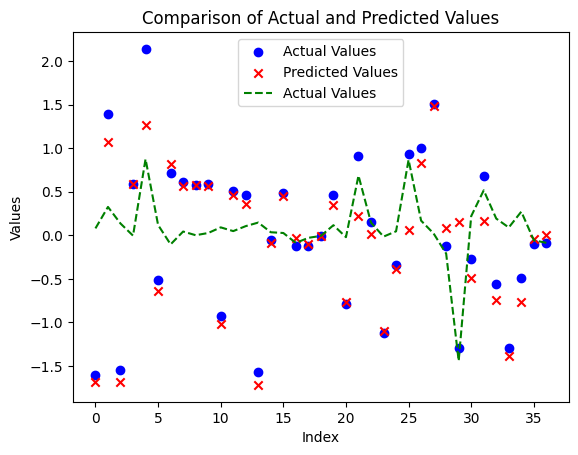

In [24]:
type(actual[0])
actual_list = list(actual[0])
predictions_list = list(predictions[0])
x_values = list(range(len(actual_list)))
difference = actual - predictions
difference_list = list(difference[0])
# Plot the actual values
plt.scatter(x_values, actual_list, color='blue', label='Actual Values', marker='o')

# Plot the predicted values
plt.scatter(x_values, predictions_list, color='red', label='Predicted Values', marker='x')

plt.plot(x_values, difference_list, color='green', label='Actual Values', linestyle='--')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Actual and Predicted Values')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [36]:
type(difference_list)

NameError: name 'difference_list' is not defined

# Train Agent

In [50]:
class Agent:
    def __init__(self):
        pass

    def choose_action(self, state):
        # For simplicity, let's assume the agent alters a random element
        # in the state by adding a small random value to it
        action = np.random.choice(range(37))  # Randomly choose which element to modify
        modification = np.random.uniform(-0.1, 0.1)  # Random change
        return action, modification

    def apply_action(self, state, action, modification):
        # Modify the chosen element in the state
        new_state = np.copy(state)
        new_state[action] += modification
        return new_state


In [ ]:
# Initialize agent
agent = Agent()

# Create a window of previous states (e.g., randomly initialized for simplicity)
#current_window = np.random.rand(1, window_size, 37)  # Shape: (1, 20, 37)

# real window from dataset
# Reshape the input from data_array to add the batch dimension
current_window = data_array[:19, :].reshape(1, 19, data_array.shape[1])  # (1, 19, 37)


# Loop through multiple episodes
for episode in range(100):  # Number of episodes
    for t in range(100):  # Time steps in each episode
        # Step 1: Predict the next state using the LSTM environment model
        predicted_next_state = swat_lstm.predict(current_window)

        # Step 2: Agent chooses an action to modify the state
        action, modification = agent.choose_action(predicted_next_state[0])

        # Step 3: Apply the action (modification) to the predicted state
        modified_state = agent.apply_action(predicted_next_state[0], action, modification)

        # Step 4: Update the input window by adding the modified state to it
        # Shift window, add modified state as the last timestep
        current_window = np.roll(current_window, shift=-1, axis=1)  # Shift the window
        current_window[0, -1, :] = modified_state  # Add modified state to the last position

        # Reward: Define a reward based on how well the chosen element is maximized
        target_name = 'LIT101'
        # get component position in 37 element list
        target_pos = component_map.index(target_name)
        reward = modified_state[target_pos]  # Reward is based on this element's value

        # Here, you would typically train your agent using an RL algorithm
        # This could involve storing transitions (state, action, reward, next_state)
        # and updating the policy/agent using an algorithm like Q-learning, DDPG, or PPO

    # End of episode: Evaluate performance, adjust hyperparameters, etc.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
print('test')